# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing libraries</a></div><div class="lev1 toc-item"><a href="#Reading-the-data-from-HDF5-files" data-toc-modified-id="Reading-the-data-from-HDF5-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading the data from HDF5 files</a></div><div class="lev1 toc-item"><a href="#Aggregating-data" data-toc-modified-id="Aggregating-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Aggregating data</a></div><div class="lev1 toc-item"><a href="#Plotting-the-data" data-toc-modified-id="Plotting-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plotting the data</a></div><div class="lev2 toc-item"><a href="#Getting-correct-labels" data-toc-modified-id="Getting-correct-labels-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Getting correct labels</a></div><div class="lev2 toc-item"><a href="#Plotting-with-interaction" data-toc-modified-id="Plotting-with-interaction-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Plotting with interaction</a></div><div class="lev1 toc-item"><a href="#Plotting-on-aggregated-data" data-toc-modified-id="Plotting-on-aggregated-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting on aggregated data</a></div>

# Notebook to analyze data
- From simulations using [SMPyBandits](https://smpybandits.github.io/).
- Author: [Lilian Besson](https://perso.crans.org/besson/)
- Date: May 2019
- License: [MIT License](https://lbesson.mit-license.org/)

## Goal

In the current folder there is a lot of [HDF5](http://www.h5py.org/) files, containing data from lots of simulations of multi-armed bandit problems.
The goal of this notebook is to read this data and to analyze it, in order to visualize it in an interactive way.

### Experimental protocol
The simulations contained a small number of algorithms (16), for single-player multi-armed bandit problems.
It only studied Bernoulli distributed arms, and various values we used for the two main parameters of a problem.
We considered different values of $K$, the number of arms, from $K=2$ to $K=32$, and different values of $T$, the horizon of the problem, from $T=1000$ to $T=50000$.

Each simulation was performed $100$ independent times, and various measurements were made and stored for each algorithms.
The main measurements are
+ the regret, a measure of performance of an algorithm,
+ the (real world) computation times (in milli seconds),
+ and the (real world) memory storage (in bytes).

We want to plot the regret in fonction of time or memory, in order to observe the following point:
+ the simplest (and oldest) algorithms (like UCB) perform pretty well and are efficient in terms of time and memory,
+ more recent or more complicated algorithms (like BayesUCB, AdBandits, kl-UCB-switch etc) usually perform more efficiently in terms of regret (ie, a small regret) but cost more.

### Conclusion
The conclusions we draw from these simulations and the analysis are twofold:
1. for applications were simplicity and low time and memory consumption are important, we can reasonably use the simple UCB algorithm instead of more complicated solutions,
2. for applications were asymptotic optimality and efficiency matters, the kl-UCB algorithm is a more efficient solution in terms of regret while being still pretty efficient in terms of time and memory costs, and it remains enough explicit and simple to manipulate to be used in mathematical proofs.

**For my thesis, the conclusion justifies why we used UCB in Chapter 4, and kl-UCB in Chapters 5 and 6.**

---
## Importing libraries

In [101]:
%load_ext watermark
%watermark -v -m -a "Lilian Besson" -p numpy,h5py,matplotlib,ipywidgets,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Lilian Besson 

CPython 3.5.2
IPython 7.2.0

numpy 1.16.1
h5py 2.9.0
matplotlib 3.0.2
ipywidgets 7.4.2
seaborn 0.9.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.15.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


In [2]:
import glob
import numpy as np
import h5py

In [3]:
%matplotlib notebook
from ipywidgets import interact, interactive

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="hls", font="sans-serif", font_scale=1.2)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)

## Reading the data from HDF5 files

There is a lot of data files:

In [102]:
!ls *.hdf5 | tail
!ls *.hdf5 | wc

main____env1-1_8408910253054733130.hdf5
main____env1-1_8468601938456229859.hdf5
main____env1-1_8645091234843248135.hdf5
main____env1-1_8659734614102119786.hdf5
main____env1-1_8725599565279277021.hdf5
main____env1-1_8867095837846687961.hdf5
main____env1-1_8970076408457402726.hdf5
main____env1-1_9103600717832324390.hdf5
main____env1-1_964142621806641457.hdf5
main____env1-1_965434151711715198.hdf5
    101     101    4027


In [5]:
list_of_files = glob.glob("*.hdf5")

In [7]:
nbOfFiles = len(list_of_files)
print("There is {} HDF5 files in the current folder.".format(nbOfFiles))

There is 101 HDF5 files in the current folder.


We can open all the files, and check that they all come from a simulation comparing the same (number of) algorithms.

In [8]:
dict_of_files = {
    itspath: h5py.File(itspath)
    for itspath in list_of_files
}

In [10]:
nbPolicies = (list(dict_of_files.values()))[0].attrs['nbPolicies']

# They all used the same number of policies!
assert all(d.attrs['nbPolicies'] == nbPolicies for d in list(dict_of_files.values()))

print("There is {} policies in these simulations".format(nbPolicies))

There is 16 policies in these simulations


## Exploring one dataset

Just to be more explicit about the content of these data file, let's manually explore one of them, to begin with.

In [79]:
one_file = list(dict_of_files.values())[0]

In [80]:
one_file

<HDF5 file "main____env1-1_3163129397996548706.hdf5" (mode r+)>

In [81]:
list(one_file.attrs)

['averageOn',
 'cache_rewards',
 'delta_t_plot',
 'finalRanksOnAverage',
 'horizon',
 'labels',
 'moreAccurate',
 'nbPolicies',
 'nb_break_points',
 'number_of_envs',
 'plot_lowerbound',
 'random_invert',
 'random_shuffle',
 'repetitions',
 'showplot',
 'signature',
 'useJoblib',
 'useJoblibForPolicies']

In [88]:
list(one_file.items())

[('env_0', <HDF5 group "/env_0" (14 members)>),
 ('rewards', <HDF5 dataset "rewards": shape (16, 1, 25000), type "<f8">)]

In [91]:
env_0 = f['env_0']

In [94]:
list(env_0.attrs)

['isChangingAtEachRepetition',
 'isMarkovian',
 'maxArm',
 'means',
 'minArm',
 'nbArms']

In [96]:
list(env_0.items())

[('allPulls', <HDF5 dataset "allPulls": shape (16, 20, 25000), type "<i4">),
 ('averageRewards',
  <HDF5 dataset "averageRewards": shape (16, 25000), type "<f8">),
 ('bestArmPulls',
  <HDF5 dataset "bestArmPulls": shape (16, 25000), type "<f8">),
 ('cumulatedRegret',
  <HDF5 dataset "cumulatedRegret": shape (16, 25000), type "<f8">),
 ('getMemoryConsumption',
  <HDF5 dataset "getMemoryConsumption": shape (16,), type "<f8">),
 ('getNumberOfCPDetections',
  <HDF5 dataset "getNumberOfCPDetections": shape (16,), type "<f8">),
 ('getRunningTimes',
  <HDF5 dataset "getRunningTimes": shape (16,), type "<f8">),
 ('lastPulls', <HDF5 dataset "lastPulls": shape (16, 20, 100), type "<i4">),
 ('lastRegrets', <HDF5 dataset "lastRegrets": shape (16, 100), type "<f8">),
 ('memoryConsumption',
  <HDF5 dataset "memoryConsumption": shape (16, 100), type "<f8">),
 ('numberOfCPDetections',
  <HDF5 dataset "numberOfCPDetections": shape (16, 100), type "<i4">),
 ('pulls', <HDF5 dataset "pulls": shape (16, 20

 ## Colors and markers
 We can generate a color map for these $N=16$ algorithms, and a (cycling) set of markers.

In [11]:
palette = sns.hls_palette(nbPolicies + 1)[:nbPolicies]

In [12]:
allmarkers = ['o', 'D', 'v', 'p', '<', 's', '^', '*', 'h', '>']
longlist = allmarkers * (1 + int(nbPolicies / float(len(allmarkers))))  # Cycle the good number of time
markers = longlist[:nbPolicies]  # Truncate

In [258]:
alllinestyles = ['-', '--', '-.', ':']
longlist = alllinestyles * (1 + int(nbPolicies / float(len(alllinestyles))))  # Cycle the good number of time
linestyles = longlist[:nbPolicies]  # Truncate

## Aggregating data

Let's read the numerical data from all these files, and store them in some lists.
We aggregate the data on the 2nd axis, meaning we count the average results (in terms of regret, time and memory) for the $100$ independent repetitions.

In [105]:
Ks, Ts = [], []
regrets, times, memories = [], [], []
map_of_KT_to_fileId = {}

for fileId, file in enumerate(list(dict_of_files.values())):
    T = file.attrs['horizon']
    env = file['env_0']
    K = env.attrs['nbArms']
    Ks.append(K)
    Ts.append(T)
    map_of_KT_to_fileId[(K, T)] = fileId

    one_regrets = np.mean(env['lastRegrets'], axis=1)
    regrets.append(one_regrets)
    one_times = np.mean(env['memoryConsumption'], axis=1)
    times.append(one_times)
    one_memories = np.mean(env['runningTimes'], axis=1)
    memories.append(one_memories)

print("Shape of env['lastRegrets'] =", np.shape(env['lastRegrets']))
print("Shape of env['memoryConsumption'] =", np.shape(env['memoryConsumption']))
print("Shape of env['runningTimes'] =", np.shape(env['runningTimes']))

Shape of env['lastRegrets'] = (16, 100)
Shape of env['memoryConsumption'] = (16, 100)
Shape of env['runningTimes'] = (16, 100)


We can also check which values of $K$ and $T$ were used for the simulations:

In [14]:
values_of_K = sorted(list(set(Ks)))
print("The simulations explored different values of K : {}".format(values_of_K))
values_of_T = sorted(list(set(Ts)))
print("The simulations explored different values of T : {}".format(values_of_T))

The simulations explored different values of K : [2, 3, 4, 8, 12, 16, 20, 32]
The simulations explored different values of T : [1000, 2500, 5000, 10000, 20000, 25000, 50000]


---
# Plotting the data
Now the serious part begins: we have the (mean) data for the different algorithms, for each couple $(K,T)$. We want to visualize it!

## Getting correct labels

In [15]:
labels = ["Algorithm #{}".format(policyId + 1) for policyId in range(nbPolicies) ]

In [16]:
labels = [
    r'$\varepsilon$-Greedy',
    'Explore-then-Commit',
    'Exp3++',
    'UCB',
    'kl-UCB',
    'Thompson',
    'BayesUCB',
    'AdBandits',
    'BESA',
    'MOSS-Anytime',
    'ApprFHG',
    r'UCB$\dagger$',
    'kl-UCB-switch',
    'Tsallis-Inf',
    'RCB',
    'PHE'
]

We can read the labels from the files.

In [99]:
labels = [ label.decode('utf8') for label in file.attrs['labels'].tolist() ]
print("Using labels = {}".format(labels))

Using labels = ['EpsilonDecreasing($\\varepsilon_0=0.1$)', 'ETC_KnownGap($T=2500$, $\\Delta=0.0278$, $T_0=0$)', 'Exp3++', 'UCB($\\alpha=1$)', 'kl-UCB', 'Thompson', 'BayesUCB', 'AdBandits($T=2500$, $\\alpha=0.5$)', 'BESA(non-recursive)', 'MOSS-Anytime($\\alpha=1.35$)', 'ApprFHG($T=2625$)', 'UCB$\\dagger$($T=2500$)', 'kl-UCB-switch', 'Tsallis-Inf($\\alpha=0.5$)', 'RCB(uniform)', 'PHE($a=0.5$)']


I remove every part of the labels which are in parentheses:

In [100]:
import re
labels = [ re.sub(r"\(.*\)", "", label) for label in labels ]
print("Using labels = {}".format(labels))

Using labels = ['EpsilonDecreasing', 'ETC_KnownGap', 'Exp3++', 'UCB', 'kl-UCB', 'Thompson', 'BayesUCB', 'AdBandits', 'BESA', 'MOSS-Anytime', 'ApprFHG', 'UCB$\\dagger$', 'kl-UCB-switch', 'Tsallis-Inf', 'RCB', 'PHE']


---
## Plotting with interaction

In [113]:
def plot_for_one_fileId(K=None, T=None,
                        logx=True, logy=True,
                        what_to_plot="regret_vs_time"):
    ax.clear()
    
    fileId = 0
    if (K, T) in map_of_KT_to_fileId:
            fileId = map_of_KT_to_fileId[(K, T)]
    K, T = Ks[fileId], Ts[fileId]
    
    one_times = times[fileId]
    one_memories = memories[fileId]
    one_regrets = regrets[fileId]

    # a scatter plot was nice but impossible to add legend!
    # plt.scatter(one_times, one_memories, s=one_regrets, color=palette, alpha=0.7)
    for policyId in range(nbPolicies):
        one_time    = one_times[policyId]
        one_memorie = one_memories[policyId]
        one_regret  = one_regrets[policyId]
        if what_to_plot == "regret_vs_time":
            y = one_regret
            x = one_time
        if what_to_plot == "regret_vs_memory":
            y = one_regret
            x = one_memorie
        if what_to_plot == "memory_vs_time":
            y = one_memorie
            x = one_time
        if logx: x = np.log(x)
        if logy: y = np.log(y)
        color  = palette[policyId]
        marker = markers[policyId]
        label  = labels[policyId]
        ax.plot(x, y, ms=12, color=color, marker=marker, label=label, alpha=0.6)

    fig.tight_layout(rect=[0.04, 0.04, 0.75, 0.92])
    plt.legend(loc='center left', numpoints=1, fancybox=True, framealpha=0.6, bbox_to_anchor=(1, 0.5))

    if what_to_plot == "regret_vs_time":
        plt.xlabel("Running time in milli seconds {}".format("(log scale)" if logx else ""))
        plt.ylabel("Mean regret {} ".format("(log scale)" if logy else ""))
    if what_to_plot == "regret_vs_memory":
        plt.xlabel("Memory consumption in bytes {}".format("(log scale)" if logx else ""))
        plt.ylabel("Mean regret {}".format("(log scale)" if logy else ""))
    if what_to_plot == "memory_vs_time":
        plt.xlabel("Running time in milli seconds {}".format("(log scale)" if logx else ""))
        plt.ylabel("Memory consumption in bytes {}".format("(log scale)" if logy else ""))
    plt.title("{} different algorithms\nBernoulli problem with K = {} arms and horizon T = {}".format(nbPolicies, K, T))

    plt.draw()

<IPython.core.display.Javascript object>


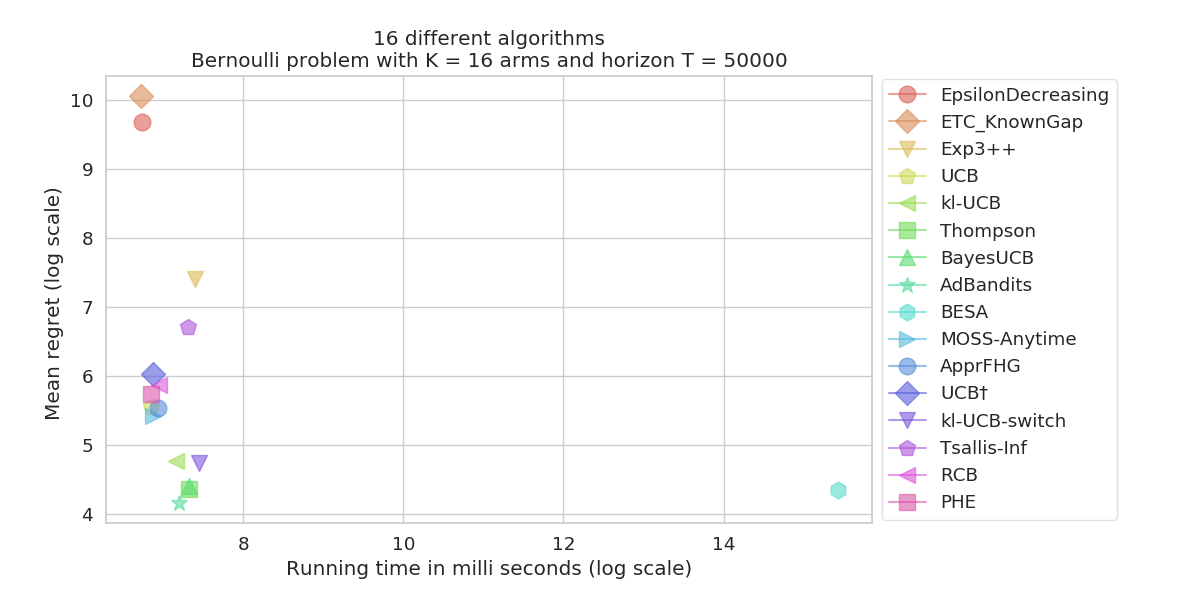

Plot was generated correctly...


In [114]:
fig, ax = plt.subplots()
plt.show()
plot_for_one_fileId()
plt.show()
print("Plot was generated correctly...")

By using [ipywidgets](https://github.com/jupyter-widgets/ipywidgets) and its function `interactive`, it's very easy to add widgets to interact with the previous function:

In [115]:
interactive_plot = interactive(plot_for_one_fileId,
   #fileId=(0, nbOfFiles-1),
   what_to_plot=["regret_vs_time", "regret_vs_memory", "memory_vs_time"],
   K=values_of_K,
   T=values_of_T,
   logx=False, logy=False,
)
display(interactive_plot)
plt.show()

interactive(children=(Dropdown(description='K', options=(2, 3, 4, 8, 12, 16, 20, 32), value=None), Dropdown(de…

---
## Plotting on aggregated data

We were able to interact with the plot and select manually the couple $(K,T)$, to visualize results for one simulation only.
Now we aggregate the data again, and visualize the mean measurements (in terms of regret, time and memory), for all the different values of $K$ and $T$ that were considered.

Here, there were $N=16$ algorithms, in $101$ different simulations:

In [22]:
np.array(times).shape

(101, 16)

In [30]:
def plot_for_aggregated_data(logx=True, logy=True,
                             what_to_plot="regret_vs_time"):
    ax.clear()
    
    mean_times = np.mean(np.array(times), axis=0)
    mean_memories = np.mean(np.array(memories), axis=0)
    mean_regrets = np.mean(np.array(regrets), axis=0)

    #plt.scatter(one_times, one_memories, s=one_regrets, color=palette, alpha=0.7)
    for policyId in range(nbPolicies):
        one_time    = mean_times[policyId]
        one_memorie = mean_memories[policyId]
        one_regret  = mean_regrets[policyId]
        if what_to_plot == "regret_vs_time":
            y = one_regret
            x = one_time
        if what_to_plot == "regret_vs_memory":
            y = one_regret
            x = one_memorie
        if what_to_plot == "memory_vs_time":
            y = one_memorie
            x = one_time
        if logx: x = np.log(x)
        if logy: y = np.log(y)
        color  = palette[policyId]
        marker = markers[policyId]
        label  = labels[policyId]
        ax.plot(x, y, ms=12, color=color, marker=marker, label=label, alpha=0.6)

    fig.tight_layout(rect=[0.04, 0.04, 0.75, 0.92])
    plt.legend(loc='center left', numpoints=1, fancybox=True, framealpha=0.6, bbox_to_anchor=(1, 0.5))

    if what_to_plot == "regret_vs_time":
        plt.xlabel("Running time in milli seconds {}".format("(log scale)" if logx else ""))
        plt.ylabel("Mean regret {}".format("(log scale)" if logy else ""))
    if what_to_plot == "regret_vs_memory":
        plt.xlabel("Memory consumption in bytes {}".format("(log scale)" if logx else ""))
        plt.ylabel("Mean regret {}".format("(log scale)" if logy else ""))
    if what_to_plot == "memory_vs_time":
        plt.xlabel("Running time in milli seconds {}".format("(log scale)" if logx else ""))
        plt.ylabel("Memory consumption in bytes {}".format("(log scale)" if logy else ""))
    plt.title("{} different algorithms\nmean results from {} different Bernoulli problems\nwith different number of arms $K = {}$\nand different horizons $T = {}$".format(nbPolicies, len(values_of_K) * len(values_of_T), values_of_K, values_of_T))

    plt.draw()

<IPython.core.display.Javascript object>


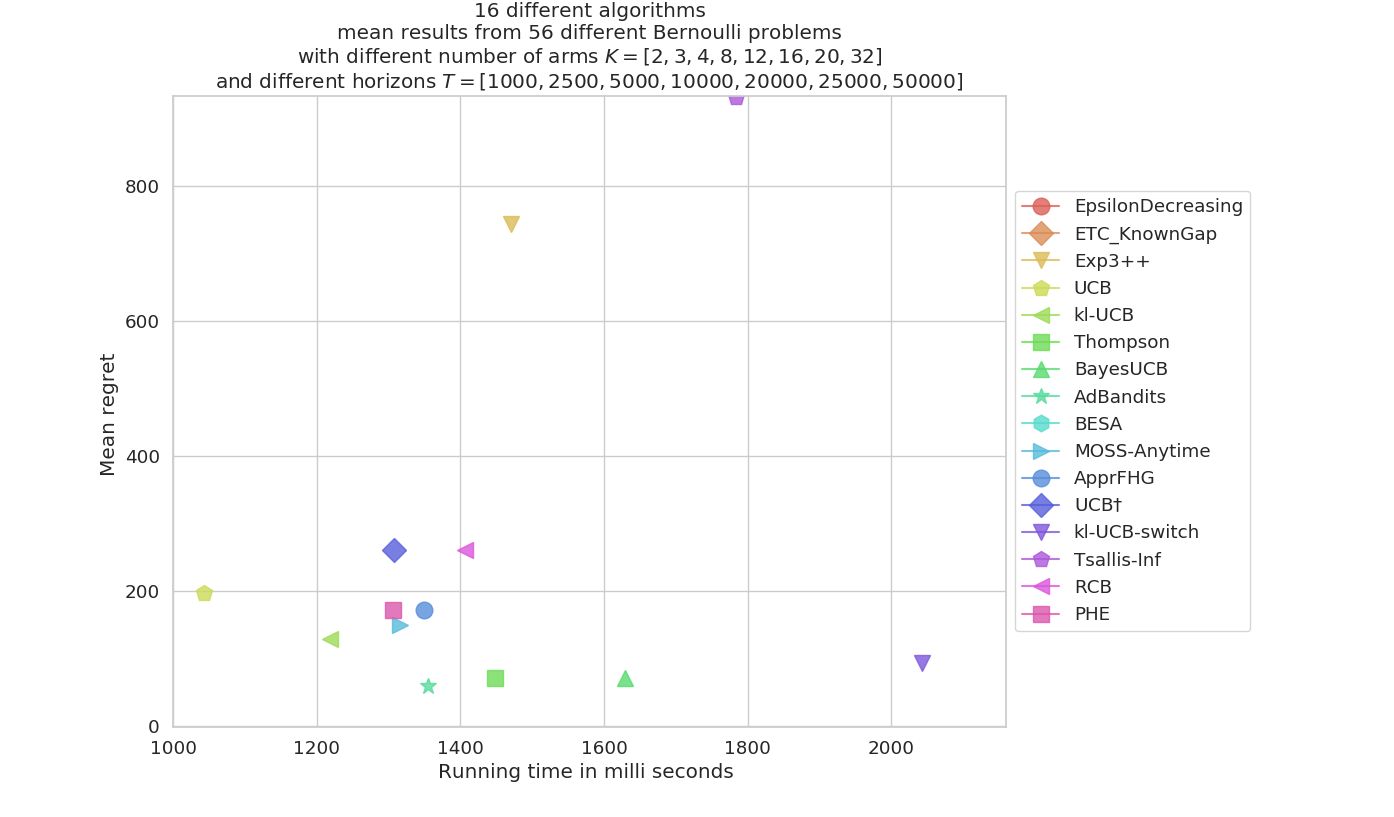

Plot was generated correctly...


In [31]:
fig, ax = plt.subplots()
plt.show()
plot_for_aggregated_data()
plt.show()
print("Plot was generated correctly...")

In [39]:
plt.savefig("16_different_algorithms__regret_vs_logmemory__56pb__7KS_7Ts.png")
plt.savefig("16_different_algorithms__regret_vs_logmemory__56pb__7KS_7Ts.pdf")

In [32]:
interactive_plot = interactive(plot_for_aggregated_data,
   what_to_plot=["regret_vs_time", "regret_vs_memory", "memory_vs_time"],
   logx=False, logy=False,
)
display(interactive_plot)
plt.show()

interactive(children=(Checkbox(value=False, description='logx'), Checkbox(value=False, description='logy'), Dr…

## Plotting on normalized data

What if we want to count not the average of regrets $R_T(K)$ for different values of $K$ and $T$ but the average of *normalized* regret $R_T(K) / (K \log(T))$ ?

- The regret will be divided by $K \log(T)$, as efficient algorithms are expected to have a regret bounded by $\mathcal{O}(K \log(T))$, and only the constant matters,
- The computation time will be divided by $K T$, as efficient algorithms are expected to have a computation time bounded by $\mathcal{O}(K T)$, and only the constant matters,
- The storage cost will be divided by $K$, as efficient algorithms are expected to have a storage cost bounded by $\mathcal{O}(K)$ (independent of $T$ !), and only the constant matters.

In [60]:
def plot_for_one_fileId_normalized(K=None, T=None,
                        logx=True, logy=True,
                        what_to_plot="regret_vs_time"):
    ax.clear()
    
    fileId = 0
    if (K, T) in map_of_KT_to_fileId:
        fileId = map_of_KT_to_fileId[(K, T)]
    K, T = Ks[fileId], Ts[fileId]
    
    one_times    = times[fileId] / (K * T)
    one_memories = memories[fileId] / (K)
    one_regrets  = regrets[fileId] / (K * np.log(T))

    #plt.scatter(one_times, one_memories, s=one_regrets, color=palette, alpha=0.7)
    for policyId in range(nbPolicies):
        one_time    = one_times[policyId]
        one_memorie = one_memories[policyId]
        one_regret  = one_regrets[policyId]
        if what_to_plot == "regret_vs_time":
            y = one_regret
            x = one_time
        if what_to_plot == "regret_vs_memory":
            y = one_regret
            x = one_memorie
        if what_to_plot == "memory_vs_time":
            y = one_memorie
            x = one_time
        if logx: x = np.log(x)
        if logy: y = np.log(y)
        color  = palette[policyId]
        marker = markers[policyId]
        label  = labels[policyId]
        ax.plot(x, y, ms=12, color=color, marker=marker, label=label, alpha=0.6)

    fig.tight_layout(rect=[0.04, 0.04, 0.75, 0.92])
    plt.legend(loc='center left', numpoints=1, fancybox=True, framealpha=0.6, bbox_to_anchor=(1, 0.5))

    if what_to_plot == "regret_vs_time":
        plt.xlabel("Normalized running time in milli seconds {}".format("(log scale)" if logx else ""))
        plt.ylabel("Normalized mean regret {} ".format("(log scale)" if logy else ""))
    if what_to_plot == "regret_vs_memory":
        plt.xlabel("Normalized memory consumption in bytes {}".format("(log scale)" if logx else ""))
        plt.ylabel("Normalized mean regret {}".format("(log scale)" if logy else ""))
    if what_to_plot == "memory_vs_time":
        plt.xlabel("Normalized running time in milli seconds {}".format("(log scale)" if logx else ""))
        plt.ylabel("Normalized memory consumption in bytes {}".format("(log scale)" if logy else ""))
    plt.title("{} different algorithms\nBernoulli problems with K = {} arms and horizon T = {}".format(nbPolicies, K, T))

    plt.draw()

<IPython.core.display.Javascript object>


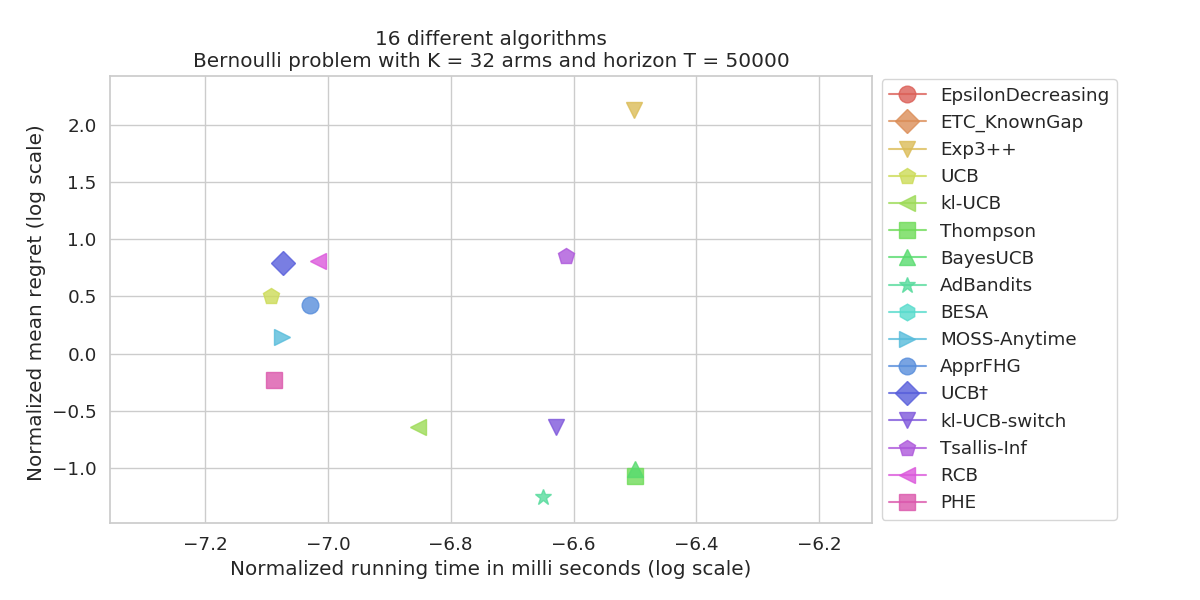

Plot was generated correctly...


In [273]:
fig, ax = plt.subplots()
plt.show()
plot_for_one_fileId_normalized()
plt.show()
print("Plot was generated correctly...")

In [274]:
interactive_plot = interactive(plot_for_one_fileId_normalized,
   #fileId=(0, nbOfFiles-1),
   what_to_plot=["regret_vs_time", "regret_vs_memory", "memory_vs_time"],
   K=values_of_K,
   T=values_of_T,
   logx=False, logy=False,
)
display(interactive_plot)
plt.show()

interactive(children=(Dropdown(description='K', options=(2, 3, 4, 8, 12, 16, 20, 32), value=None), Dropdown(de…

## Plotting on normalized aggregated data
Now for the aggregated data!

In [116]:
def plot_for_aggregated_normalized_data(logx=True, logy=True,
                             what_to_plot="regret_vs_time"):
    ax.clear()
    
    mean_times    = []
    mean_memories = []
    mean_regrets  = []
    
    numberOfIds = len(map_of_KT_to_fileId)
    for (K, T) in map_of_KT_to_fileId:
        # if K != 20: continue
        # if T != 10000: continue
        fileId = map_of_KT_to_fileId[(K, T)]
    
        one_times    = 1000 * times[fileId] / (K * T)
        mean_times.append(one_times)

        one_memories = memories[fileId] / K
        mean_memories.append(one_memories)

        one_regrets  = regrets[fileId] / (K * np.log(T))
        mean_regrets.append(one_regrets)
        
        if False: print("""
        - For K = {}, T = {}, we had:
          normalized times = {}
          normalized memories = {}
          normalized regrets = {}""".format(
            K, T,
            np.round(one_times, 2),
            np.round(one_memories, 2),
            np.round(one_regrets, 2),
        ))

    mean_times = np.mean(mean_times, axis=0)
    mean_memories = np.mean(mean_memories, axis=0)
    mean_regrets = np.mean(mean_regrets, axis=0)

    for policyId in range(nbPolicies):
        one_time    = mean_times[policyId]
        one_memorie = mean_memories[policyId]
        one_regret  = mean_regrets[policyId]
        if what_to_plot == "regret_vs_time":
            y = one_regret
            x = one_time
        if what_to_plot == "regret_vs_memory":
            y = one_regret
            x = one_memorie
        if what_to_plot == "memory_vs_time":
            y = one_memorie
            x = one_time
        if logx: x = np.log(x)
        if logy: y = np.log(y)
        color  = palette[policyId]
        marker = markers[policyId]
        label  = labels[policyId]
        ax.plot(x, y, ms=12, color=color, marker=marker, label=label, alpha=0.6)

    fig.tight_layout(rect=[0.04, 0.04, 0.75, 0.92])
    plt.legend(loc='center left', numpoints=1, fancybox=True, framealpha=0.6, bbox_to_anchor=(1, 0.5))

    if what_to_plot == "regret_vs_time":
        plt.xlabel("Normalized running time in micro-seconds {}".format("(log scale)" if logx else ""))
        plt.ylabel("Normalized mean regret {}".format("(log scale)" if logy else ""))
    if what_to_plot == "regret_vs_memory":
        plt.xlabel("Normalized memory consumption in bytes {}".format("(log scale)" if logx else ""))
        plt.ylabel("Normalized mean regret {}".format("(log scale)" if logy else ""))
    if what_to_plot == "memory_vs_time":
        plt.xlabel("Normalized running time in milli seconds {}".format("(log scale)" if logx else ""))
        plt.ylabel("Normalized memory consumption in bytes {}".format("(log scale)" if logy else ""))
    plt.title("{} different algorithms\nNormalized mean results from {} different Bernoulli problems\nwith different number of arms $K = {}$\nand different horizons $T = {}$".format(nbPolicies, len(values_of_K) * len(values_of_T), values_of_K, values_of_T))

    plt.draw()

<IPython.core.display.Javascript object>


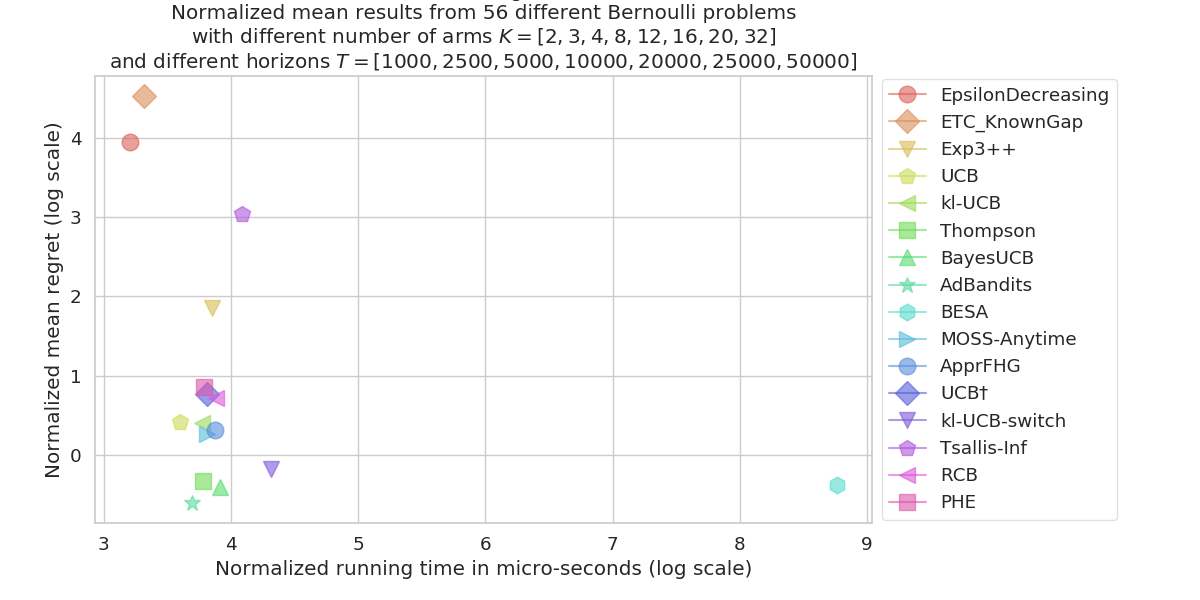

Plot was generated correctly...


In [132]:
fig, ax = plt.subplots()
plt.show()
plot_for_aggregated_normalized_data()
plt.show()
print("Plot was generated correctly...")

In [131]:
plt.savefig("16_different_algorithms__normmemory_vs_normtime__56pb__7KS_7Ts.png")
plt.savefig("16_different_algorithms__normmemory_vs_normtime__56pb__7KS_7Ts.pdf")

In [133]:
interactive_plot = interactive(plot_for_aggregated_normalized_data,
   what_to_plot=["regret_vs_time", "regret_vs_memory", "memory_vs_time"],
   logx=False, logy=False,
)
display(interactive_plot)
plt.show()

interactive(children=(Checkbox(value=False, description='logx'), Checkbox(value=False, description='logy'), Dr…

---
## Plotting regret, time and memory as a function of nb of arms

In [271]:
def plot_regret_vs_arms(logy=True,
                        onlyT=10000,
                        what_to_plot="regret_vs_arms"):
    ax.clear()
    
    all_times    = { K: {} for K in values_of_K }
    all_memories = { K: {} for K in values_of_K }
    all_regrets  = { K: {} for K in values_of_K }
    
    numberOfIds = len(map_of_KT_to_fileId)
    for (K, T) in map_of_KT_to_fileId:
        if onlyT is not None and T != onlyT: continue  # we skip it!
        fileId = map_of_KT_to_fileId[(K, T)]
    
        one_times    = times[fileId] / T
        if T in all_times[K]:
            all_times[K][T].append(one_times)
        else:
            all_times[K][T] = [one_times]

        one_memories = memories[fileId]
        if T in all_memories[K]:
            all_memories[K][T].append(one_memories)
        else:
            all_memories[K][T] = [one_memories]

        one_regrets  = regrets[fileId] / np.log(T)
        if T in all_regrets[K]:
            all_regrets[K][T].append(one_regrets)
        else:
            all_regrets[K][T] = [one_regrets]


    for policyId in range(nbPolicies):
        Xs = []
        Ys = []
        for K in values_of_K:
            for all_t, all_m, all_r in zip(
                    all_times[K].values(),
                    all_memories[K].values(),
                    all_regrets[K].values()
            ):
                a_t = np.mean(all_t, axis=0)
                a_m = np.mean(all_m, axis=0)
                a_r = np.mean(all_r, axis=0)
                one_time    = a_t[policyId]
                one_memorie = a_m[policyId]
                one_regret  = a_r[policyId]
                if what_to_plot == "regret_vs_arms":
                    y = one_regret
                if what_to_plot == "memory_vs_arms":
                    y = one_memorie
                if what_to_plot == "time_vs_arms":
                    y = one_time
                if logy: y = np.log(y)
                # store one more data for this policy!
                Xs.append(K)
                Ys.append(y)
        # done for getting data for this policy!
        color  = palette[policyId]
        marker = markers[policyId]
        label  = labels[policyId]
        linestyle = linestyles[policyId]
        ax.plot(Xs, Ys, ls=linestyle, lw=0.75, marker=marker, ms=12, color=color, alpha=0.6)

    fig.tight_layout(rect=[0.04, 0.04, 0.75, 0.92])
    plt.legend(labels, loc='center left', numpoints=1, fancybox=True, framealpha=0.6, bbox_to_anchor=(1, 0.5))

    plt.xlabel("Number of arms")
    if what_to_plot == "regret_vs_arms":
        plt.ylabel("Normalized mean regret {} {}".format(r"$\frac{R_T}{\log(T)}$", "(log scale)" if logy else ""))
    if what_to_plot == "memory_vs_arms":
        plt.ylabel("Memory consumption in bytes {}".format("(log scale)" if logy else ""))
    if what_to_plot == "time_vs_arms":
        plt.ylabel("Normalized running time in milli seconds {} {}".format(r"$\frac{\mathcal{T}_T}{T}$", "(log scale)" if logy else ""))
    plt.title("{} different algorithms\nNormalized mean results from {} different Bernoulli problems\nfor horizon $T = {}$".format(nbPolicies, len(values_of_K) * len(values_of_T), onlyT if onlyT is not None else values_of_T))

    plt.draw()

<IPython.core.display.Javascript object>


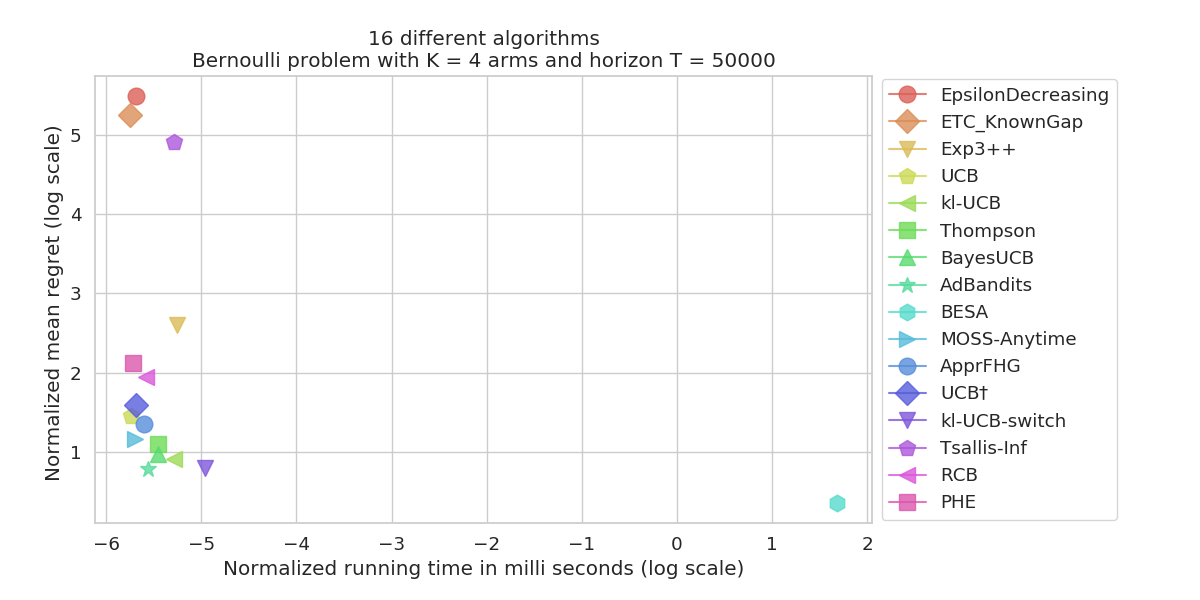

Plot was generated correctly...


In [272]:
fig, ax = plt.subplots()
plt.show()
plot_regret_vs_arms()
plt.show()
print("Plot was generated correctly...")

In [235]:
plt.savefig("16_different_algorithms__lognormregret_vs_arms__56pb__7Ks_T50000.png")
plt.savefig("16_different_algorithms__lognormregret_vs_arms__56pb__7Ks_T50000.pdf")

In [234]:
interactive_plot = interactive(plot_regret_vs_arms,
   what_to_plot=["regret_vs_arms", "memory_vs_arms", "time_vs_arms"],
   onlyT=[None] + values_of_T,
   logy=False,
)
display(interactive_plot)
plt.show()

interactive(children=(Checkbox(value=False, description='logy'), Dropdown(description='onlyT', index=4, option…

---
## Plotting regret, time and memory as a function of horizon

In [269]:
def plot_regret_vs_horizons(logx=False, logy=False,
        onlyK=8,
        what_to_plot="regret_vs_horizons"):
    ax.clear()
    
    all_times    = { T: {} for T in values_of_T }
    all_memories = { T: {} for T in values_of_T }
    all_regrets  = { T: {} for T in values_of_T }
    
    numberOfIds = len(map_of_KT_to_fileId)
    for (K, T) in map_of_KT_to_fileId:
        if onlyK is not None and K != onlyK: continue  # we skip it!
        fileId = map_of_KT_to_fileId[(K, T)]
    
        one_times    = times[fileId] / K
        if K in all_times[T]:
            all_times[T][K].append(one_times)
        else:
            all_times[T][K] = [one_times]

        one_memories = memories[fileId] / K
        if K in all_memories[T]:
            all_memories[T][K].append(one_memories)
        else:
            all_memories[T][K] = [one_memories]

        one_regrets  = regrets[fileId] / K
        if K in all_regrets[T]:
            all_regrets[T][K].append(one_regrets)
        else:
            all_regrets[T][K] = [one_regrets]


    for policyId in range(nbPolicies):
        Xs = []
        Ys = []
        for T in values_of_T:
            for all_t, all_m, all_r in zip(
                    all_times[T].values(),
                    all_memories[T].values(),
                    all_regrets[T].values()
            ):
                a_t = np.mean(all_t, axis=0)
                a_m = np.mean(all_m, axis=0)
                a_r = np.mean(all_r, axis=0)
                one_time    = a_t[policyId]
                one_memorie = a_m[policyId]
                one_regret  = a_r[policyId]
                if what_to_plot == "regret_vs_horizons":
                    y = one_regret
                if what_to_plot == "memory_vs_horizons":
                    y = one_memorie
                if what_to_plot == "time_vs_horizons":
                    y = one_time
            if logy: y = np.log(y)
            Tused = np.log(T) if logx else T
            Xs.append(Tused)
            Ys.append(y)
        # done for getting data for this policy!
        color  = palette[policyId]
        marker = markers[policyId]
        label  = labels[policyId]
        linestyle = linestyles[policyId]
        ax.plot(Xs, Ys, ls=linestyle, lw=0.75, marker=marker, ms=12, color=color, alpha=0.6)

    fig.tight_layout(rect=[0.04, 0.04, 0.75, 0.92])
    plt.legend(labels, loc='center left', numpoints=1, fancybox=True, framealpha=0.6, bbox_to_anchor=(1, 0.5))

    plt.xlabel("Different values of $T$ the horizon of the experiment {}".format("(log scale)" if logx else ""))
    if what_to_plot == "regret_vs_horizons":
        plt.ylabel("Normalized mean regret {} {}".format(r"$\frac{R_T}{K}$", "(log scale)" if logy else ""))
    if what_to_plot == "memory_vs_horizons":
        plt.ylabel("Normalized memory consumption in bytes {} {}".format(r"$\frac{\mathcal{M}_T}{K}$", "(log scale)" if logy else ""))
    if what_to_plot == "time_vs_horizons":
        plt.ylabel("Normalized running time in milli seconds {} {}".format(r"$\frac{\mathcal{T}_T}{K}$", "(log scale)" if logy else ""))
    plt.title("{} different algorithms\nNormalized mean results from {} different Bernoulli problems\nwith number of arms $K = {}$".format(nbPolicies, len(values_of_K) * len(values_of_T), onlyK if onlyK is not None else values_of_K))

    plt.draw()

<IPython.core.display.Javascript object>


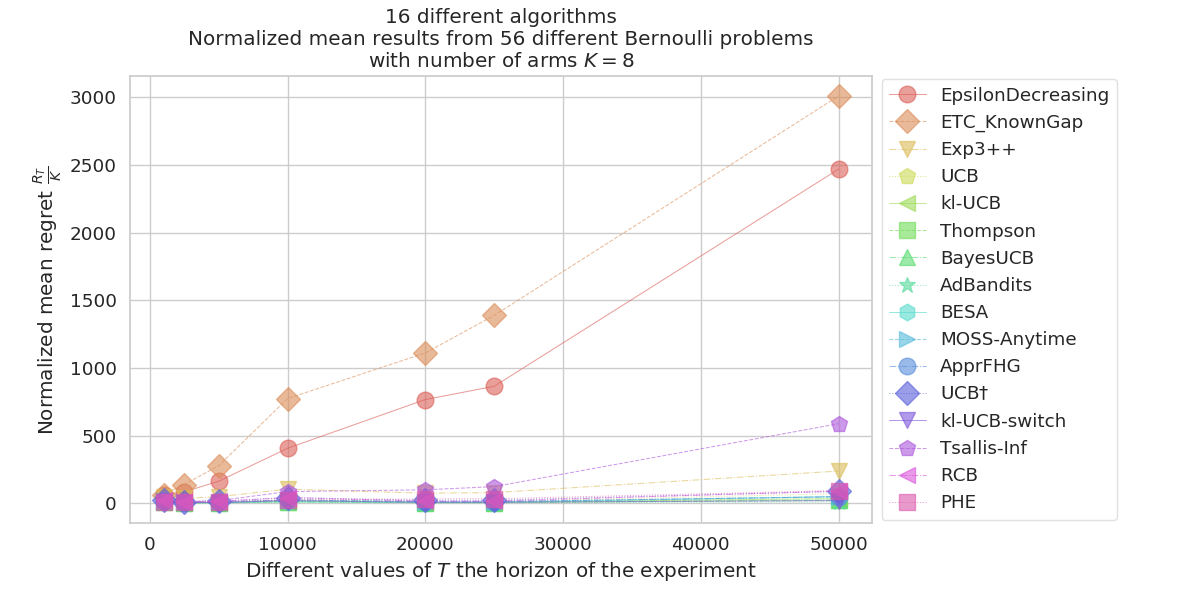

Plot was generated correctly...


In [270]:
fig, ax = plt.subplots()
plt.show()
plot_regret_vs_horizons()
plt.show()
print("Plot was generated correctly...")

In [245]:
plt.savefig("16_different_algorithms__normregret_vs_horizons__56pb__K32_7Ts.png")
plt.savefig("16_different_algorithms__normregret_vs_horizons__56pb__K32_7Ts.pdf")

In [264]:
interactive_plot = interactive(plot_regret_vs_horizons,
   what_to_plot=["regret_vs_horizons", "memory_vs_horizons", "time_vs_horizons"],
   onlyK=[None] + values_of_K,
   logy=False,
)
display(interactive_plot)
plt.show()

interactive(children=(Checkbox(value=False, description='logx'), Checkbox(value=False, description='logy'), Dr…